# Data Synchronization

Updated on: 09.01.2025 </br>

Main changes: New Synchronization Method between EMG and Ultrasound, tests conducted with oscilloscope.

Protocol: sending a pulse evert 10 seconds, to detect if there is a mis-alignment over time

In [6]:
import sys

sys.path.append(r'C:\Users\giusy\OneDrive\Desktop\HGR\manus-acquisition\data_synchronization')
from biogui_utils import *
from pathlib import Path

%matplotlib widget
import matplotlib.pyplot as plt

In [7]:
data_directory = Path(r"C:\Users\giusy\OneDrive\Desktop\HGR\biogui\synch_tests\20250114")
#data_directory = Path(r"C:\Users\giusy\OneDrive\Desktop\HGR_data\20250116\wrist")

In [8]:
acq_names =  ["2025-01-14_16-38-42"]      

wulpus_files = ["wulpus_2025-01-14_16-38-42.npz"]
                       

In [9]:
acq_idx = 0

In [10]:
acq_name = acq_names[acq_idx]

print(f'Data main directory: {data_directory}')
emg_file = data_directory/f"emg_{acq_name}.bin"
wulpus_trigger = data_directory/f"triggerWulpus_{acq_name}.bin"
counter_file = data_directory/f"counter_{acq_name}.bin"


Data main directory: C:\Users\giusy\OneDrive\Desktop\HGR\biogui\synch_tests\20250114


In [11]:
    
# Create dataframe containing acquired EMG data
print('Processing EMG data...\n')
fs_emg = 500
if fs_emg is not None:
    print(f'EMG data sampled at: {fs_emg} Hz')
else:
    fs_emg = 500
    print(f'Using default EMG sampling rate: 500 Hz')

EMG_Dataset = EMG_dataset(emg_file, num_channels=8, trigger_gui=True, fs_emg=fs_emg, filter=True)
emg_df_raw = EMG_Dataset.emg_raw_df.reset_index()


emg_df_filt = EMG_Dataset.emg_filter_df.reset_index()
# Originally it increases every 2 ms, now set progressive indexes

emg_df = emg_df_raw



Processing EMG data...

EMG data sampled at: 500 Hz
Created EMG dataframe with columns:Index(['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Trigger_gui',
       'Timestamp', 'Timestamp_reconstructed'],
      dtype='object')


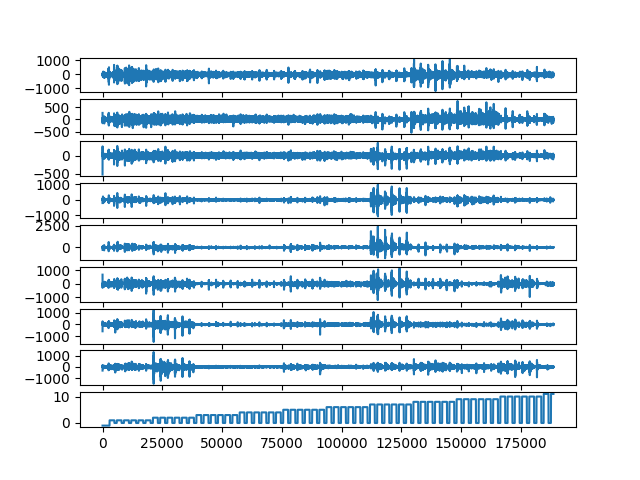

In [12]:
fig, axs = plt.subplots(9, 1, sharex=True)

for i in range(1, 9):
    axs[i-1].plot(emg_df_filt[f'Ch{i}'])
axs[i].plot(emg_df_raw['Trigger_gui'])



In [13]:
def read_counter(filePath, trigger_gui=True):
    '''
    filePath: str
    Note: File Containing Counter for BIOGAP data
    '''
    # Read data
    with open(filePath, "rb") as f:
        nCh = struct.unpack("<I", f.read(4))[0]
        bSig = bytes(f.read())
    sig = np.frombuffer(bSig, dtype='float32').reshape(-1, nCh).T
    data = sig.T

    # Data Contains: Counter (updated every BLE packet - every 14 ms), Progressive Counter, 
    # Wulpus Counter (Not in use atm), Timestamps

    # Considering for now only the progressive counter, the trigger gui and the timestamps
    if trigger_gui == True:
        counter_df = pd.DataFrame()
        # If we keep the GUI open, counter doesn't start from 0
        # TODO: change the FW
        counter_df['EMG_counter_header'] = data[:, 0]
        counter_df["EMG_counter"] = data[:, 1] - data[0, 1]
        counter_df["Trigger_gui"] = data[:, -2]
        counter_df["Timestamp"] = data[:, -1]

    else:
        counter_df['EMG_counter_header'] = data[:, 0]
        counter_df = pd.DataFrame()
        counter_df["EMG_counter"] = data[:, 1] - data[0, 1]
        counter_df["Timestamp"] = data[:, -1]

        
    return counter_df

In [14]:
## Extract file that contains the counter
counter_df = read_counter(counter_file, trigger_gui=True)

In [15]:
counter_df['EMG_counter']

0              0.0
1              1.0
2              2.0
3              3.0
4              4.0
            ...   
188603    188603.0
188604    188604.0
188605    188605.0
188606    188606.0
188607    188607.0
Name: EMG_counter, Length: 188608, dtype: float32

In [16]:
counter_df['EMG_counter_header'].diff()!=0

0          True
1         False
2         False
3         False
4         False
          ...  
188603    False
188604    False
188605    False
188606    False
188607    False
Name: EMG_counter_header, Length: 188608, dtype: bool

In [17]:
# check where the sequence restarts

# This filters the counter for every BLE packet (expected indexes to have an increase of 7 samples)
new_packet_locs = counter_df['EMG_counter_header'][counter_df['EMG_counter_header'].diff() !=0].iloc[1:]


In [18]:
# We expect an increase of 7 

np.where(np.diff(new_packet_locs.index)!=7)

(array([], dtype=int64),)

In [19]:
np.diff(new_packet_locs.index)


array([7, 7, 7, ..., 7, 7, 7], dtype=int64)

In [20]:
print(f"Lost BIOGAP samples: {len(np.where(np.diff(counter_df['EMG_counter'])!=1)[0])}")

Lost BIOGAP samples: 0


In [21]:
# Get the unique timestamps and their counts
unique_timestamps, counts = np.unique(emg_df['Timestamp'], return_counts=True)

# Initialize the reconstructed timestamp list
reconstructed_time = np.linspace(unique_timestamps[0] - 0.002*counts[0], unique_timestamps[0], counts[0])

# Start from the first unique timestamp minus a small step (for extrapolation if necessary)
prev_timestamp = reconstructed_time[-1]

# Loop through unique timestamps and interpolate
for i, (current_timestamp, count) in enumerate(zip(unique_timestamps[1:], counts[1:])):
    # Interpolate linearly between the previous last timestamp and the current unique timestamp
    interpolated = np.linspace(prev_timestamp, current_timestamp, count+1, endpoint=True)
    reconstructed_time = np.append(reconstructed_time, interpolated[1:])
    
    # Update the previous timestamp for the next iteration
    prev_timestamp = interpolated[-1]



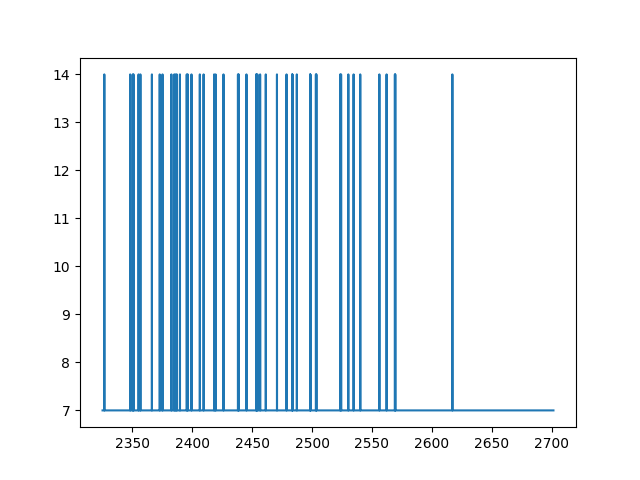

In [22]:
plt.figure()
plt.plot(unique_timestamps, counts)
plt.show()

In [23]:
""" plt.figure()
plt.plot(np.diff(emg_df['Timestamp_reconstructed']))
plt.show() """

" plt.figure()\nplt.plot(np.diff(emg_df['Timestamp_reconstructed']))\nplt.show() "

In [24]:
# plt.figure()
# plt.plot(emg_df['Timestamp_reconstructed'].iloc[:21], emg_df['Ch1'].iloc[:21])

In [25]:
def read_trigger_wulpus_new(filePath, trigger_gui=True):
    '''
    filePath: str
    Note: we are WULPUS trigger synchronization signal
    '''
    # Read data
    with open(filePath, "rb") as f:
        nCh = struct.unpack("<I", f.read(4))[0]
        bSig = bytes(f.read())
    
    # Trigger Wulpus New stores in the MSB the Synchronization Signal 
    sig = np.frombuffer(bSig, dtype='float32').reshape(-1, nCh).T
    data = sig.T
    if trigger_gui == True:
    # Extracting also trigger information 
        columns = ["Trigger_Wulpus", "Trigger_gui", "Timestamp"]
        trigger_df = pd.DataFrame(data, columns=columns)

    else:
    # Extracting also trigger information 
        columns = ["Trigger_Wulpus", "Timestamp"]
        trigger_df = pd.DataFrame(data, columns=columns)
        
    return trigger_df


In [26]:
trigger_wulpus_df = read_trigger_wulpus_new(wulpus_trigger, trigger_gui=True)


In [27]:
trigger_wulpus_df

,Trigger_Wulpus,Trigger_gui,Timestamp
0,0.0,-1.0,2325.100830
1,0.0,-1.0,2325.100830
2,0.0,-1.0,2325.100830
3,0.0,-1.0,2325.100830
4,0.0,-1.0,2325.100830
...,...,...,...
188603,1.0,11.0,2701.505615
188604,1.0,11.0,2701.505615
188605,1.0,11.0,2701.505615
188606,1.0,11.0,2701.505615


In [28]:
emg_df = pd.concat((emg_df, trigger_wulpus_df['Trigger_Wulpus'], counter_df['EMG_counter']), axis=1)

In [29]:
emg_df

,index,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Trigger_gui,Timestamp,Timestamp_reconstructed,Trigger_Wulpus,EMG_counter
0,0,22.013983,316.937775,-619.252502,-248.193741,-311.692566,799.179077,-680.088989,-398.794800,-1.0,2325.100098,2325.086098,0.0,0.0
1,2,39.140385,320.235901,-617.384888,-240.206726,-307.798401,800.212219,-690.976807,-389.973328,-1.0,2325.100098,2325.088431,0.0,1.0
2,4,103.155769,324.527435,-608.603149,-238.259628,-308.752075,794.251770,-717.202820,-432.252869,-1.0,2325.100098,2325.090764,0.0,2.0
3,6,168.720886,362.912811,-577.648499,-230.034195,-308.791809,799.338013,-701.626160,-419.259064,-1.0,2325.100098,2325.093098,0.0,3.0
4,8,153.024994,395.695374,-557.223938,-225.345291,-304.659210,803.112976,-695.864380,-416.199371,-1.0,2325.100098,2325.095431,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188603,377206,47.524769,324.010864,-603.755310,-260.035187,-344.832733,757.972412,-688.473389,-422.557190,11.0,2701.504883,2701.503627,1.0,188603.0
188604,377208,120.321907,346.899048,-594.655701,-253.796570,-321.030609,810.543701,-663.320251,-399.589539,11.0,2701.504883,2701.503941,1.0,188604.0
188605,377210,136.017792,351.707153,-597.874329,-242.670380,-294.486694,820.994385,-690.261536,-406.304993,11.0,2701.504883,2701.504255,1.0,188605.0
188606,377212,86.704887,339.666992,-601.649292,-237.941742,-289.837524,811.378174,-688.513123,-412.821777,11.0,2701.504883,2701.504569,1.0,188606.0


In [30]:
# Now, check EMG Ble losses
#Count BLE losses 
emg_losses= np.where(np.diff(emg_df['EMG_counter'])!=1)[0]
count_emg_losses = (len(emg_losses))
print(f"Lost:{count_emg_losses} BIOGAP packets")


Lost:0 BIOGAP packets


In [31]:
# 50 us samples -> 500 emg samples


In [32]:
# Define Now Ultrasound locations
# We get a trigger Signal every 50 Ultrasound frames
wps_trigger_diff = emg_df['Trigger_Wulpus'].diff()             # note .diff() already takes into account the first element (set to NaN)
wulpus_50_locs = wps_trigger_diff!=0 
print(wulpus_50_locs)      

0          True
1         False
2         False
3         False
4         False
          ...  
188603    False
188604    False
188605    False
188606    False
188607    False
Name: Trigger_Wulpus, Length: 188608, dtype: bool


In [33]:
idx_wulpus = wps_trigger_diff[wps_trigger_diff!=0].index.values
# add the initial index manually (change the FW to send first trigger at the first pulse and not after 50)
#idx_wulpus[0] = idx_wulpus[1] - 500
print(idx_wulpus)
if idx_wulpus[0] == 0:
    idx_wulpus = idx_wulpus[1:]

[     0   2625   3126   3627   4128   4629   5130   5631   6132   6632
   7133   7634   8135   8636   9137   9638  10139  10640  11141  11642
  12143  12644  13145  13646  14147  14647  15148  15649  16150  16651
  17152  17653  18154  18655  19156  19657  20158  20659  21159  21660
  22161  22662  23163  23664  24165  24666  25167  25668  26169  26670
  27170  27671  28172  28673  29174  29675  30176  30677  31178  31679
  32180  32681  33182  33683  34183  34684  35185  35686  36187  36688
  37189  37690  38191  38692  39193  39694  40195  40696  41196  41697
  42198  42699  43200  43701  44202  44703  45204  45705  46206  46707
  47208  47709  48209  48710  49211  49712  50213  50714  51215  51716
  52217  52718  53219  53719  54220  54721  55222  55723  56224  56725
  57226  57727  58228  58729  59230  59730  60231  60732  61233  61734
  62235  62736  63237  63738  64239  64740  65241  65742  66243  66744
  67245  67745  68246  68747  69248  69749  70250  70751  71252  71753
  7225

In [34]:
idx_wulpus         # are the indices in the emg dataframe

array([  2625,   3126,   3627,   4128,   4629,   5130,   5631,   6132,
         6632,   7133,   7634,   8135,   8636,   9137,   9638,  10139,
        10640,  11141,  11642,  12143,  12644,  13145,  13646,  14147,
        14647,  15148,  15649,  16150,  16651,  17152,  17653,  18154,
        18655,  19156,  19657,  20158,  20659,  21159,  21660,  22161,
        22662,  23163,  23664,  24165,  24666,  25167,  25668,  26169,
        26670,  27170,  27671,  28172,  28673,  29174,  29675,  30176,
        30677,  31178,  31679,  32180,  32681,  33182,  33683,  34183,
        34684,  35185,  35686,  36187,  36688,  37189,  37690,  38191,
        38692,  39193,  39694,  40195,  40696,  41196,  41697,  42198,
        42699,  43200,  43701,  44202,  44703,  45204,  45705,  46206,
        46707,  47208,  47709,  48209,  48710,  49211,  49712,  50213,
        50714,  51215,  51716,  52217,  52718,  53219,  53719,  54220,
        54721,  55222,  55723,  56224,  56725,  57226,  57727,  58228,
      

In [35]:
np.diff(idx_wulpus)

array([501, 501, 501, 501, 501, 501, 501, 500, 501, 501, 501, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 500, 501, 501, 501,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500,
       501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 500,
       501, 501, 501, 501, 501, 500, 501, 501, 501, 501, 501, 501, 501,
       501, 501, 501, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501,
       501, 501, 501, 501, 501, 500, 501, 501, 501, 501, 501, 50

In [36]:
np.mean(np.diff(idx_wulpus))

500.9318181818182

In [37]:
# cut everthing after first wulpus frame
#emg_df = emg_df.loc[idx_wulpus[0]:, :]
# Reset the index such that we start from 0 for simplicity
#emg_df = emg_df.reset_index(drop=True)
#emg_df['index_from_0'] = emg_df.index.values - emg_df.index.values[0]
#emg_df


In [38]:
# plt.figure()
# plt.plot(emg_df['Trigger_Wulpus'])
# plt.plot(idx_wulpus, emg_df['Trigger_Wulpus'].loc[idx_wulpus], marker='o', linestyle='none')
# plt.show()

# every idx wulpus (dot) corresponds to the 50th - 100th ... etc ultrasound frame 


# Read Wulpus

In [39]:
from US_dataset import *

In [40]:
data = np.load(data_directory/wulpus_files[acq_idx])
acq_num_arr= data['acq_num_arr']

print(f'Max acq num arr:{np.max(acq_num_arr)}')
acquired_samples = np.where(acq_num_arr == np.max(acq_num_arr))[0][0]
expected_samples = np.max(acq_num_arr)

print(f'Acquired:{acquired_samples}')
print(f'Expected:{expected_samples}')
losts = expected_samples-acquired_samples
print(f'Lost:{losts}')
    
us_raw_data = data['data_arr']
us_raw_data = us_raw_data[:, :acquired_samples+1]
us_tx_idx_arr = data['tx_rx_id_arr']
us_tx_idx_arr = us_tx_idx_arr[:acquired_samples+1]
acq_num_arr = data['acq_num_arr'] [:acquired_samples+1]
print(f'last acq_num_arr:{acq_num_arr[-1]}')


Max acq num arr:17656
Acquired:16999
Expected:17656
Lost:657
last acq_num_arr:17656


 ...]

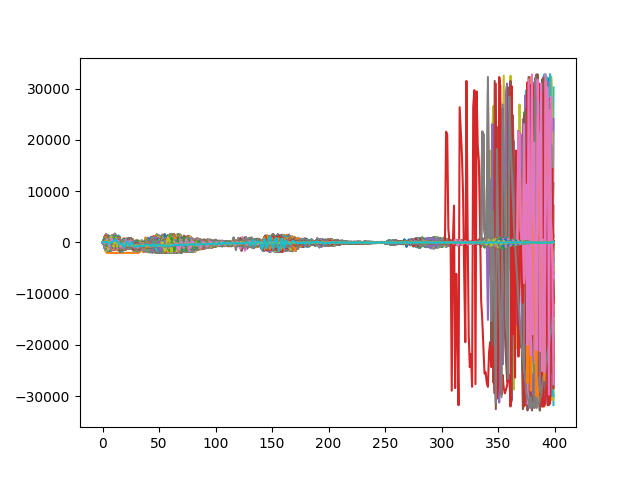

In [45]:
plt.figure()
plt.plot(us_raw_data)

In [48]:
# As we can see, there are some instances where the values acquired go outside the expected range
# We go far off the expected ADC ranges

defect_samples_acq_num_array = []
defect_sample_abs_loc = []
for cnt_us in range(us_raw_data.shape[1]):
    curr_us = us_raw_data[:, cnt_us]

    # Detect the maximum value
    if(np.max(curr_us) > 2000):
        #print(f'Defect at idx: {acq_num_arr[cnt_us]}')
        defect_samples_acq_num_array.append(acq_num_arr[cnt_us])
        defect_sample_abs_loc.append(cnt_us)

print(f'Got: {len(defect_samples_acq_num_array)} Defected samples')

Got: 40 Defected samples


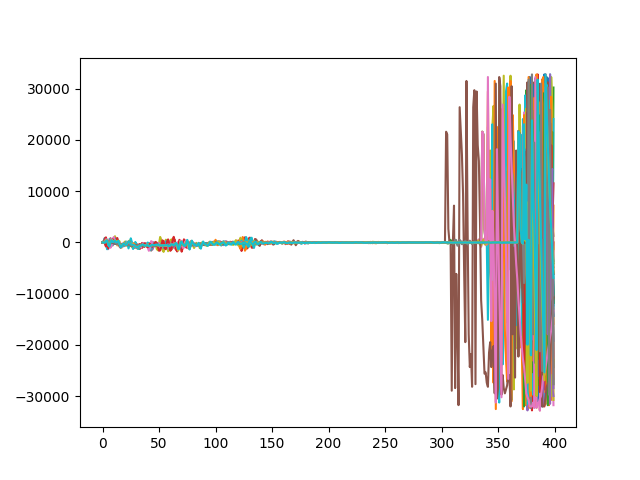

In [49]:
plt.figure()

for curr_defect in defect_sample_abs_loc:     plt.plot(us_raw_data[:, curr_defect])

In [373]:
acq_num_arr

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=uint16)

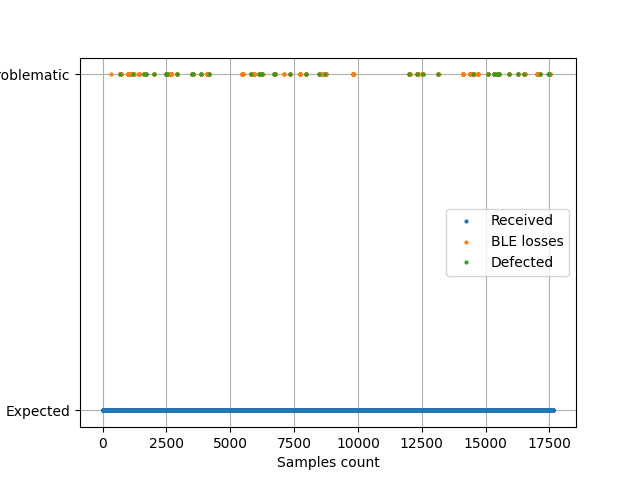

In [47]:
expected_idx = np.arange(acq_num_arr[-1]+1)

plt.figure()

plt.plot(np.intersect1d(expected_idx, acq_num_arr), np.ones(len(np.intersect1d(expected_idx, acq_num_arr))), 
         marker='o', markersize=2, linestyle='None', label='Received')
plt.plot(np.setxor1d(expected_idx, acq_num_arr), 1.2*np.ones(len(np.setxor1d(expected_idx, acq_num_arr))),
        marker='o', markersize=2, linestyle='None', label='BLE losses')
plt.plot(np.intersect1d(expected_idx, defect_samples_acq_num_array), 1.2*np.ones(len(np.intersect1d(expected_idx, defect_samples_acq_num_array))),
        marker='o', markersize=2, linestyle='None',label='Defected')
plt.legend()
plt.xlabel('Samples count')
plt.yticks([1, 1.2], ['Expected', 'Problematic'])
plt.grid()


In [375]:
# the maximum index value should correspond to the last acquisition number array acquired 
# If we loose samples, the US data corresponding to this expected idx will be set to NaN
expected_idx = np.arange(acq_num_arr[-1]+1)
us_df = pd.DataFrame(index=expected_idx)

# assing data to the corresponding ultrasound frames
us_df.loc[acq_num_arr, 'Transducer'] = us_tx_idx_arr.astype(int)
# Assign 'Transducer_Data' column with arrays
us_raw_transp = us_raw_data.T
us_df.loc[acq_num_arr, 'Transducer_Data'] = pd.Series(list(us_raw_transp), index=acq_num_arr)




In [376]:
# tx_data_before_fix = us_df['Transducer_Data'].values
# plt.figure()
# for tx in tx_data_before_fix:
#     plt.plot(tx)

In [377]:
# # Checking the locations of defected samples
# defected = us_df.loc[defect_samples_acq_num_array]['Transducer_Data']
# plt.figure()
# for curr_defect in defected:
#     plt.plot(curr_defect)

In [378]:
us_df.loc[defect_samples_acq_num_array, 'Transducer_Data'] = np.nan

In [ ]:
6

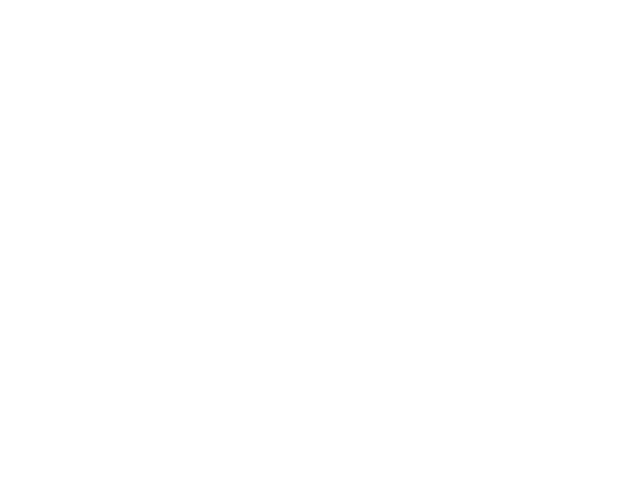

In [379]:
defected = us_df.loc[defect_samples_acq_num_array]['Transducer_Data']
plt.figure()
for curr_defect in defected:
    plt.plot(curr_defect)

In [380]:
# Identify Locations with Nan Values, corresponding to BLE Losses for Wulpus
nan_locs = us_df[us_df['Transducer'].isna() == True].index

In [381]:
# dummy ultrasound data
#us_dummy = us_df.iloc[1]['Transducer_Data']
#us_df.loc[nan_locs, 'Transducer_Data'] = pd.Series([us_dummy for _ in range(len(nan_locs))], index=nan_locs)

In [382]:
us_df.loc[nan_locs]

us_df.loc[nan_locs, 'Missing_Tx'] = 1
us_df.loc[acq_num_arr, 'Missing_Tx'] = 0

In [383]:


test_acquisitions = False
for curr_nan in nan_locs:
    # check the value of the transducer at previous location
    prev_trans = us_df.loc[curr_nan-1, 'Transducer']
    print(f'previous trans value: {prev_trans}')
    if test_acquisitions:
        missing_trans_idx = 0
    else:
        if prev_trans == 3:
            missing_trans_idx = 0
        else:
            missing_trans_idx = prev_trans + 1
    us_df.loc[curr_nan, 'Transducer'] = missing_trans_idx
   
    print(us_df.loc[curr_nan, 'Transducer'])

In [384]:
# This is to check that we are handling correctly missing data
print(len(us_df[us_df['Missing_Tx']==1]))

0


In [385]:
us_df[us_df['Transducer_Data'].isna()].shape[0]

0

In [386]:
print(f"Number of nan values:{us_df[us_df['Transducer_Data'].isna()].shape[0]}")
print(f"Number of BLE losses:{losts}")
print(f"Number of defected samples:{len(defect_sample_abs_loc)}")
if(losts+len(defect_sample_abs_loc) == us_df[us_df['Transducer_Data'].isna()].shape[0]):
    print('Numbers match')

Number of nan values:0
Number of BLE losses:0
Number of defected samples:0
Numbers match


In [387]:
# now, we need to assing every batch of 50 ultrasound frames (1 second) to the corresponding batch of EMG data 

freq_scaling = 500 / 50
counter_every_50_frames = 49                    # 
combined_df = emg_df.copy()

cnt_wulpus_batch = 0

wulpus_bloks = []
for idx_wulpus_cnt, idx_wulpus_biogap in enumerate(idx_wulpus):
    #if idx_wulpus_biogap!=idx_wulpus[-1]:

    
    print(f'Batch number:{cnt_wulpus_batch}')
    start_wulpus_batch = cnt_wulpus_batch * 50
    if idx_wulpus_biogap!=idx_wulpus[-1]:
        stop_wulpus_batch = start_wulpus_batch + 49
    else:
        stop_wulpus_batch = acq_num_arr[-1]
    print(f'Considering US frames from:{start_wulpus_batch} to {stop_wulpus_batch}')
    if start_wulpus_batch <= len(us_df):
        us_df_curr = us_df.loc[start_wulpus_batch:stop_wulpus_batch]
        print(f'Current US df has len: {len(us_df_curr)}')
        print(f"Lost:{len(us_df_curr[us_df_curr['Transducer_Data'].isna()==True])} US frames for this batch")
        
        # idx wulpus biogap corresponds to the 50th - 100th .... Ultrasound frame
        biogap_idx_start = idx_wulpus_biogap - counter_every_50_frames * freq_scaling                
        print(f'Biogap idx starts at: {biogap_idx_start}, stops at: {idx_wulpus_biogap}')
        print(f'Start - stop difference : {idx_wulpus_biogap - biogap_idx_start}')
        
        new_wps_idx = np.linspace(biogap_idx_start, idx_wulpus_biogap, num = len(us_df_curr), dtype=int)
        wulpus_bloks.extend([new_wps_idx[0], new_wps_idx[-1]])
        print(new_wps_idx)
        
        us_curr_acq_num_arr = us_df_curr.index
        print(us_curr_acq_num_arr)
        us_df_curr = us_df_curr.set_index(new_wps_idx)

        combined_df.loc[new_wps_idx, 'Transducer'] = us_df_curr['Transducer']
        combined_df.loc[new_wps_idx, 'Transducer_Data'] = us_df_curr['Transducer_Data']
        combined_df.loc[new_wps_idx, 'US acq_num_array'] =us_curr_acq_num_arr
        combined_df.loc[new_wps_idx, 'Missing_Tx'] = us_df_curr['Missing_Tx']
        #print(combined_df.loc[new_wps_idx, 'US acq_num_array'])
        cnt_wulpus_batch+=1
        
        
    #else:
        # enter here for the last (max) 50 samples acquired
    #    print('last batch')
    print('---')

# assign all the remainin samples
# start_wulpus_batch = cnt_wulpus_batch * 50
# stop_wulpus_batch = acq_num_arr[-1]
# us_df_curr = us_df.loc[start_wulpus_batch:]
# us_curr_acq_num_arr = us_df_curr.index
# print(f'Considering US frames from:{start_wulpus_batch} to {stop_wulpus_batch}')
# remaining_samples = stop_wulpus_batch-start_wulpus_batch + 1
# print(f'Remianing:{remaining_samples} samples')

# biogap_idx_start = new_wps_idx[-1] + freq_scaling
# new_wps_idx = np.linspace(biogap_idx_start, biogap_idx_start + remaining_samples*freq_scaling, remaining_samples, dtype=int)
# print(new_wps_idx)
# us_df_curr = us_df_curr.set_index(new_wps_idx)

# àcombined_df.loc[new_wps_idx, 'Transducer'] = us_df_curr['Transducer']
# combined_df.loc[new_wps_idx, 'Transducer_Data'] = us_df_curr['Transducer_Data']
# combined_df.loc[new_wps_idx, 'US acq_num_array'] =us_curr_acq_num_arr
# wulpus_bloks.extend([new_wps_idx[0], new_wps_idx[-1]])

Batch number:0
Considering US frames from:0 to 49
Current US df has len: 50
Lost:0 US frames for this batch
Biogap idx starts at: 743.0, stops at: 1233
Start - stop difference : 490.0
[ 743  753  763  773  783  793  803  813  823  833  843  853  863  873
  883  893  903  913  923  933  943  953  963  973  983  993 1003 1013
 1023 1033 1043 1053 1063 1073 1083 1093 1103 1113 1123 1133 1143 1153
 1163 1173 1183 1193 1203 1213 1223 1233]
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype='int32')
---
Batch number:1
Considering US frames from:50 to 99
Current US df has len: 50
Lost:0 US frames for this batch
Biogap idx starts at: 1244.0, stops at: 1734
Start - stop difference : 490.0
[1244 1254 1264 1274 1284 1294 1304 1314 1324 1334 1344 1354 1364 1374
 1384 1394 1404 1414 1424 1434 1444 1454 1464 1474 1484 1

In [388]:
start_wulpus_batch

9950

In [389]:
len(us_df)

10000

In [390]:
# plt.figure()
# plt.plot(emg_df['Trigger_Wulpus'])
# plt.plot(wulpus_bloks, emg_df['Trigger_Wulpus'].loc[wulpus_bloks], marker='o', linestyle='none')
# plt.show()

In [391]:
combined_df = combined_df.loc[idx_wulpus[0] - 490: combined_df[combined_df['Transducer_Data'].isna() == False].index[-1], :]

In [392]:
print(f'Acquired: {acquired_samples + 1} for Wulpus')

Acquired: 10000 for Wulpus


In [393]:
from scipy import signal as ss
# Filter Ultrasound Data
f_low = 0.55 * US_PRR
f_high = 1.45 * US_PRR

b, a = ss.butter(4, [f_low / (US_FS / 2), f_high / (US_FS / 2)], btype='bandpass')
index_not_nan = combined_df[combined_df['Transducer_Data'].isna()==False].index
data_filtered = ss.filtfilt(b, a, np.vstack(combined_df.loc[index_not_nan, 'Transducer_Data']))

# Hilbert Envelope Extraction
data_env = np.abs(hilbert(data_filtered, axis=1))

# Create a copy of the DataFrame for processed data
combined_df_proc = combined_df.copy()

# Assign filtered and envelope data to the new DataFrame
combined_df_proc.loc[index_not_nan, 'Transducer_Data_Filt'] = pd.Series(list(data_filtered), index=index_not_nan)
combined_df_proc.loc[index_not_nan, 'Transducer_Data_Hilb'] = pd.Series(list(data_env), index=index_not_nan)



In [394]:
combined_df_proc[combined_df_proc['Missing_Tx']==1]


,index,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Trigger_gui,Timestamp,Timestamp_reconstructed,Trigger_Wulpus,EMG_counter,Transducer,Transducer_Data,US acq_num_array,Missing_Tx,Transducer_Data_Filt,Transducer_Data_Hilb


In [395]:
# Theo check again if we don't have defect values

# tx_values = combined_df_proc[combined_df_proc['Transducer'] == 0]['Transducer_Data']
# tx_indexes = combined_df_proc[combined_df_proc['Transducer'] == 0]['Transducer_Data'].index
# # we should expect values within max -2000 2000
# max_values = []
# min_values = []


# for idx, curr_tx in enumerate(tx_values):
#     if np.isnan(curr_tx).any():
#         #print('nan')
#         max_values.append(np.nan)
#     else:
#         max_values.append(np.max(curr_tx))
#         if(np.max(curr_tx)>2000):
#             print(f'defect, value: {np.max(curr_tx)}')


In [396]:
# curr_tx = combined_df_proc[combined_df_proc['Transducer'] == 0]['Transducer_Data']
# plt.figure()
# for tx in curr_tx:
#     plt.plot(tx)

In [397]:
def plot_sync_emg_us(df):

    # plotting some data as example
    fig, axs = plt.subplots(6, 1, sharex=True)
    plt.subplots_adjust(hspace=0.1)

    # Overall x-axis range (based on the entire combined_df)
    #x_min, x_max = combined_df['Timestamp_reconstructed'].iloc[0], combined_df['Timestamp_reconstructed'].iloc[-1]
    #x_min, x_max = df.index[0], df.index[-1]
    x_min, x_max = df.index[0], df.index[-1]
    print(x_min, x_max)
    ch_to_plot = [1, 4, 8]
    cnt_fig=0
    
    
    for i in range(len(ch_to_plot)):
        #axs[cnt_fig].plot(timestamps_emg, combined_df[f'Ch{cnt_fig+1}'].values)
        axs[cnt_fig].plot(df.index, df[f'Ch{ch_to_plot[cnt_fig]}'].values)
        
        axs[cnt_fig].set_xlim(x_min, x_max)
        axs[cnt_fig].set_title(f'EMG - Ch{ch_to_plot[cnt_fig]}')
        axs[cnt_fig].set_ylabel('Amplitude [uV]')

        cnt_fig +=1

    # Loop over the transducers
    imaging_depths = compute_us_imaging_depths()
    #print(np.where(np.isnan(np.vstack(combined_df['Transducer_Data_Hilb'])).all(axis=1))[0])

    for i in range(0,2):
        # Filter the data for the current transducer
        tx = df[df['Transducer'] == i]
        tx_start = tx.index[0]
        tx_stop = tx.index[-1]
        #tx_stop = tx.index[-1]
        
        #tx = combined_df.loc[tx_start:tx_stop:80]
        print(tx_start, tx_stop)
        # Identify rows with NaN 

        nan_rows =  tx[tx['Transducer_Data_Hilb'].isna() == True]
        #print(nan_rows)
        
        print(f'Got NaNs for current transducer:{len(nan_rows)}')

        # Create a pandas Series with arrays of 400 NaNs for the affected rows
        nan_arrays = pd.Series([np.full(400, np.nan) for _ in range(len(nan_rows))], index=nan_rows.index)
        #zero_arrays = pd.Series([np.full(400, 0) for _ in range(len(nan_rows))], index=nan_rows.index)
        # Assign the new Series to the 'Transducer_Data_Hilb' column
        tx.loc[nan_rows.index, 'Transducer_Data_Hilb'] = nan_arrays
        
        # Extract data for plotting
        us_array = np.vstack(tx['Transducer_Data_Hilb']).T
        #print(f"Shape: {us_array.shape}")
        #print(f"Data type: {us_array.dtype}")
        #print(f"Array content: {us_array}")
        #print("Non-numeric entries in us_array:")
        #print(us_array[~np.isfinite(us_array)])
        #us_array = np.vstack(tx['Transducer_Data_Hilb'].fillna(np.nan)).T
        #print(np.shape(np.isnan(us_array)))
        # Configure colormap to handle NaNs

        #cmap.set_bad(color="red")  # Set NaNs to red
        # Define extent
        extent = [
            tx_start,
            tx_stop,
            imaging_depths[-1],
            imaging_depths[0],
        ]
        
        print(extent[0], extent[1])
        # Plot the transducer data
        axs[cnt_fig].imshow(
            us_array,
            #extent=extent,
            extent=[x_min, x_max,  imaging_depths[-1],  imaging_depths[0]],
            aspect="auto",
            origin="upper",
            interpolation = "nearest", 
            #vmin=1, 
            
        )
        #axs[cnt_fig].set_xlim(x_min, x_max)
        axs[cnt_fig].set_ylabel("Depth [mm]")
            
        #axs[cnt_fig].plot(combined_df.index,combined_df['Trigger_gui'] )
        cnt_fig+=1
    axs[cnt_fig].plot(df.index, df['Trigger_gui'].values)
    axs[cnt_fig].set_xlabel('Samples')
    axs[cnt_fig].set_xlim(x_min, x_max)
    #plt.tight_layout()
    plt.show()





2912 100937
2948 100907
Got NaNs for current transducer:0
2948 100907
2918 100917
Got NaNs for current transducer:0
2918 100917


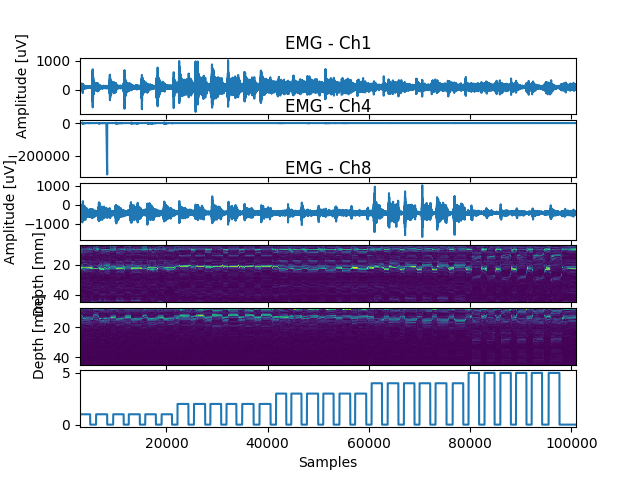

In [398]:
plot_sync_emg_us(combined_df_proc[combined_df_proc['Trigger_gui']!=-1])    